<a href="https://colab.research.google.com/github/NoCodeProgram/deepLearning/blob/main/detectSegment/segmentation_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
print(torch.__version__)

2.1.0+cu121


In [ ]:
import torch
if torch.backends.mps.is_available():
    my_device = torch.device('mps')
elif torch.cuda.is_available():
    my_device = torch.device('cuda')
else:
    my_device = torch.device('cpu')
print(my_device)


cuda


In [ ]:
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large, DeepLabV3_MobileNet_V3_Large_Weights

weights = DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT
model = deeplabv3_mobilenet_v3_large(weights=weights)

(512, 512)


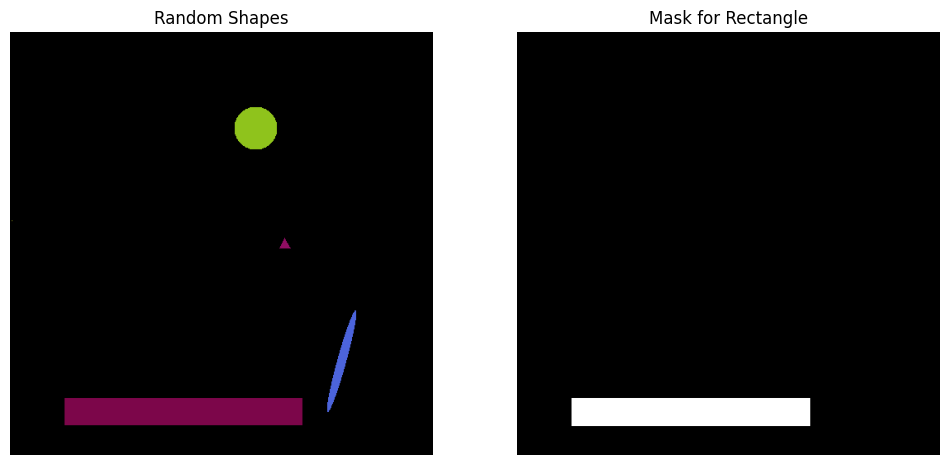

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import random_shapes, rectangle

def generate_segmentation_rect(image_size):
    image, labels = random_shapes(image_size, max_shapes=10, min_shapes=5,  allow_overlap=False)
    image = 255 - image

    mask = np.zeros(image.shape[:2], dtype=float)
    for shape, ((start_row, end_row), (start_col, end_col)) in labels:
        if shape == "rectangle":
            # print(shape, ((start_row, start_col), (end_row, end_col)) )
            rr, cc = rectangle(start=(start_row, start_col),
                                    end=(end_row, end_col),
                                    shape=image_size)
            mask[rr, cc] = 1.0

    return image, mask

image_size = (512, 512)
image, mask = generate_segmentation_rect(image_size)
print(mask.shape)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image)
ax[0].set_title('Random Shapes')
ax[0].axis('off')

ax[1].imshow(mask, cmap='gray')
ax[1].set_title('Mask for Rectangle')
ax[1].axis('off')

plt.show()

In [ ]:
from torch import nn
import torch.optim as optim

num_classes = 2

in_channels = model.classifier[-1].in_channels
aux_in_channels = model.aux_classifier[-1].in_channels

model.classifier[-1] = nn.Conv2d(
    in_channels, num_classes, kernel_size=(1, 1), stride=(1, 1)
)
model.aux_classifier[-1] = nn.Conv2d(
    aux_in_channels, num_classes, kernel_size=(1, 1), stride=(1, 1)
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

def get_batch_tensor(batch_size=8):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    images = []
    labels = []

    # Generate batch of images and labels
    for _ in range(batch_size):
        image, label = generate_segmentation_rect(image_size)

        tensor_image = TF.to_tensor(image)
        normalized_image = normalize(tensor_image)
        tensor_label = torch.from_numpy(label).long()


        images.append(normalized_image)
        labels.append(tensor_label)

    batch_images = torch.stack(images)
    batch_labels = torch.stack(labels)

    return batch_images, batch_labels

batch_images, batch_labels = get_batch_tensor(8)


In [ ]:
model.to(my_device)

model.train()
for batch_idx in range(1000):
    images, labels = get_batch_tensor(64)
    images, labels = images.to(my_device), labels.to(my_device)
    outputs = model(images)
    loss = criterion(outputs["out"], labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"batch num : {batch_idx}, loss:{loss.item()}")

model.eval()


batch num : 0, loss:0.6241456866264343
batch num : 1, loss:0.5967822074890137
batch num : 2, loss:0.5641090869903564
batch num : 3, loss:0.5492160320281982
batch num : 4, loss:0.5190452337265015
batch num : 5, loss:0.5122831463813782
batch num : 6, loss:0.4927183985710144
batch num : 7, loss:0.46422845125198364
batch num : 8, loss:0.46961262822151184
batch num : 9, loss:0.4409545361995697
batch num : 10, loss:0.42897263169288635
batch num : 11, loss:0.4027811586856842
batch num : 12, loss:0.3883732259273529
batch num : 13, loss:0.3482864201068878
batch num : 14, loss:0.32845836877822876
batch num : 15, loss:0.32203391194343567
batch num : 16, loss:0.3083423674106598
batch num : 17, loss:0.2966112196445465
batch num : 18, loss:0.29644349217414856
batch num : 19, loss:0.25976693630218506
batch num : 20, loss:0.22436398267745972
batch num : 21, loss:0.21086685359477997
batch num : 22, loss:0.19187688827514648
batch num : 23, loss:0.19597934186458588
batch num : 24, loss:0.1760842055082321

KeyboardInterrupt: ignored

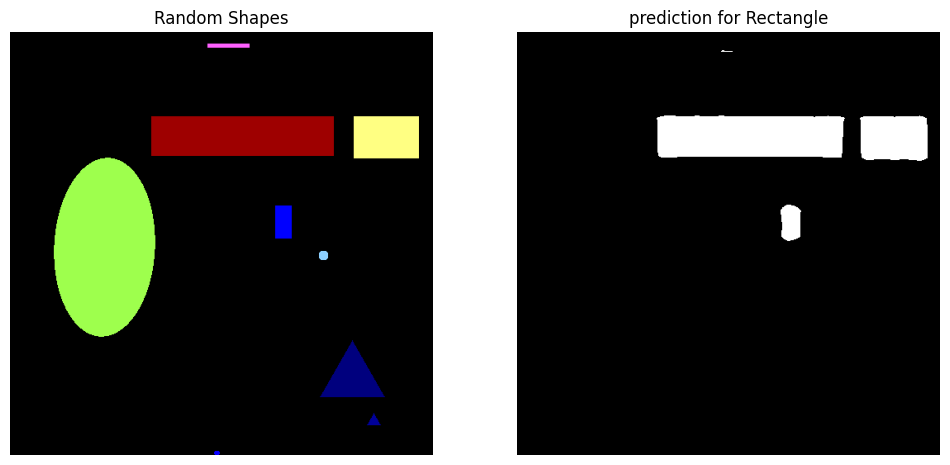

In [ ]:
model.eval()
model.to('cpu')
image, mask = get_batch_tensor(1)

with torch.no_grad():
    output = model(image)["out"]
image = image.squeeze().cpu().numpy()
image = image.transpose(1, 2, 0)

prediction = output.squeeze().cpu().numpy()
prediction = np.argmax(prediction, axis=0)
prediction = prediction * 127
prediction = prediction.astype(np.uint8)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image)
ax[0].set_title('Random Shapes')
ax[0].axis('off')

ax[1].imshow(prediction, cmap='gray')
ax[1].set_title('prediction for Rectangle')
ax[1].axis('off')

plt.show()